In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from QODE import SequenceDataset

In [2]:
target_data = pd.read_csv('./data/targ.csv')
feature_data = pd.read_csv('./data/feat.csv')

# 2. Merge the datasets
# Ensure timestamps are aligned
feature_data['time'] = pd.to_datetime(feature_data['time'])
target_data['time'] = pd.to_datetime(target_data['time'])
df = pd.merge(feature_data, target_data, on='time')


# 2. Define features and target
columns = ['wds', 'sp', 't2m']  # wind speed, surface pressure, temperature
target_column = 'wds_scaled'    # scaled wind speed is our target


# 4. Prepare the dataset
data = df[columns + [target_column]]
dataset = data.values


In [3]:
df.head()

,time,wds,sp,t2m,wds_scaled
0,2021-01-01 12:00:00,4.364394,93660.520,281.47745,0.301118
1,2021-01-02 12:00:00,3.323717,93318.860,281.67798,0.320002
2,2021-01-03 12:00:00,4.354847,93505.484,280.11860,0.313972
3,2021-01-04 12:00:00,4.204862,93287.850,280.45532,0.308259
4,2021-01-05 12:00:00,4.825264,93452.660,279.91920,0.337141


In [4]:
# Cell: Create time-inconsistent data (80% of original data)
import numpy as np

# Set fixed seed for reproducibility
np.random.seed(42)

# Store original length
original_length = len(df)

# Calculate number of rows to keep (80% of data)
n_keep = int(original_length * 0.8)

# Randomly select indices to keep
keep_indices = np.random.choice(df.index, size=n_keep, replace=False)
keep_indices = sorted(keep_indices)  # Sort indices to maintain temporal order

# Modify df directly
df = df.iloc[keep_indices].copy()
df.reset_index(drop=True, inplace=True)


df.head()

,time,wds,sp,t2m,wds_scaled
0,2021-01-01 12:00:00,4.364394,93660.520,281.47745,0.301118
1,2021-01-03 12:00:00,4.354847,93505.484,280.11860,0.313972
2,2021-01-04 12:00:00,4.204862,93287.850,280.45532,0.308259
3,2021-01-05 12:00:00,4.825264,93452.660,279.91920,0.337141
4,2021-01-06 12:00:00,3.643536,93659.950,280.21010,0.326191


In [5]:

print("Available columns:", df.columns.tolist())  # Check actual column names

Available columns: ['time', 'wds', 'sp', 't2m', 'wds_scaled']


In [6]:
# Cell 4: Split Data
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

# Create DataFrames with correct column names
df_train = pd.DataFrame(df_train, columns=columns + [target_column])
df_test = pd.DataFrame(df_test, columns=columns + [target_column])

In [7]:

features = columns
target = target_column

In [8]:
# Cell 4: Normalize Function
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

# Normalize data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [9]:
# Cell 5: Prepare DataLoaders
torch.manual_seed(101)

sequence_length = 3
batch_size = 32

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Cell 6: Model Setup
from QODE import ShallowRegressionQuantumODELSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = ShallowRegressionQuantumODELSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=14,
    num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

In [11]:
# Cell 7: Training and Testing Functions
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        if len(X.shape) == 2:
            X = X.unsqueeze(0)
        output = model(X)
        if len(output.shape) != len(y.shape):
            output = output.squeeze()
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            if len(X.shape) == 2:
                X = X.unsqueeze(0)
            output = model(X)
            if len(output.shape) != len(y.shape):
                output = output.squeeze()
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss / num_batches
    return avg_loss

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

In [12]:
# Cell 8: Train Model
num_epochs = 50
quantum_loss_train = []
quantum_loss_test = []

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    print(f"Train loss: {train_loss:.6f}, Test loss: {test_loss:.6f}")
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.058165, Test loss: 0.051596
Epoch 1
---------
Train loss: 0.039384, Test loss: 0.035241
Epoch 2
---------
Train loss: 0.031821, Test loss: 0.032215
Epoch 3
---------
Train loss: 0.025800, Test loss: 0.024280
Epoch 4
---------
Train loss: 0.022084, Test loss: 0.020171
Epoch 5
---------
Train loss: 0.018674, Test loss: 0.017103
Epoch 6
---------
Train loss: 0.016650, Test loss: 0.014424
Epoch 7
---------
Train loss: 0.015518, Test loss: 0.013420
Epoch 8
---------
Train loss: 0.013605, Test loss: 0.013024
Epoch 9
---------
Train loss: 0.013262, Test loss: 0.010632
Epoch 10
---------
Train loss: 0.012088, Test loss: 0.011866
Epoch 11
---------
Train loss: 0.012389, Test loss: 0.010880
Epoch 12
---------
Train loss: 0.012875, Test loss: 0.011289
Epoch 13
---------
Train loss: 0.014121, Test loss: 0.010237
Epoch 14
---------
Train loss: 0.012968, Test loss: 0.015022
Epoch 15
---------
Train loss: 0.012751, Test loss: 0.009478
Epoch 16
---------
Train loss: 0.0

In [13]:
# Cell 9: Make Predictions
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

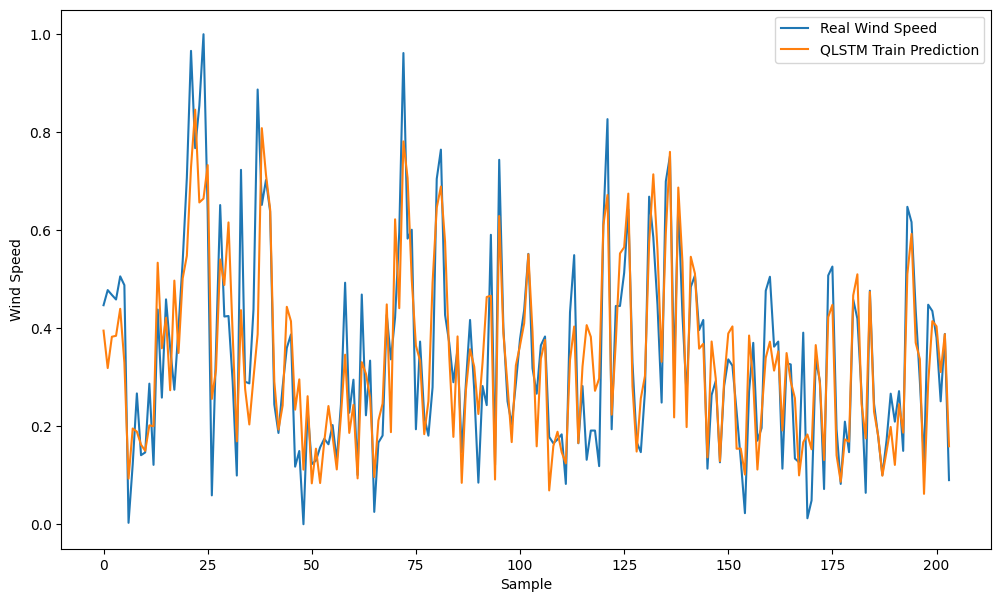

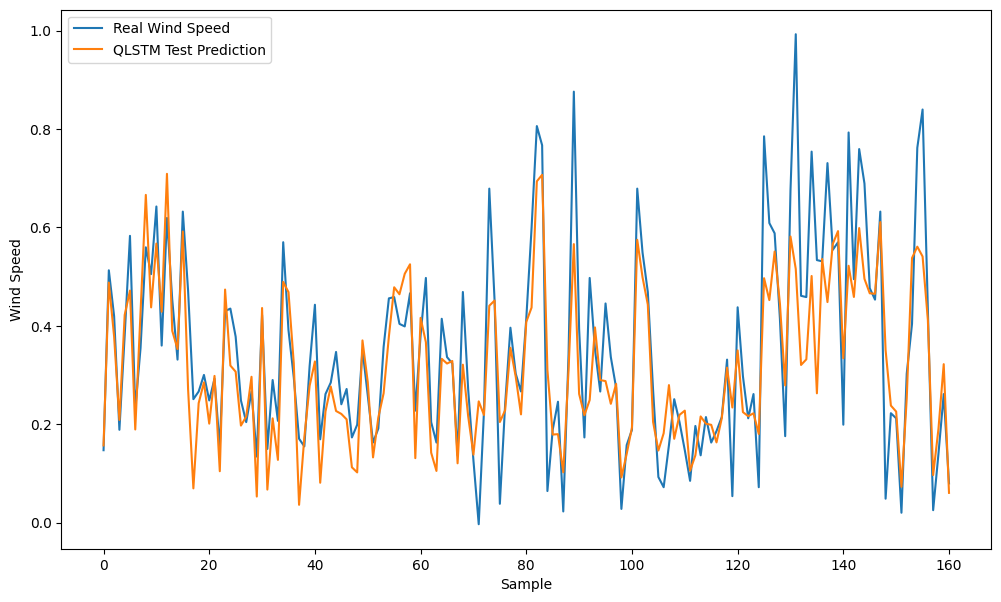

In [14]:
# Cell 10: Plot Results
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train[target], label="Real Wind Speed")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label="QLSTM Train Prediction")
plt.ylabel('Wind Speed')
plt.xlabel('Sample')
plt.legend()
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test[target], label="Real Wind Speed")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label="QLSTM Test Prediction")
plt.ylabel('Wind Speed')
plt.xlabel('Sample')
plt.legend()
plt.show()

In [15]:
# Cell 11: Calculate Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate metrics for train data
train_rmse = math.sqrt(mean_squared_error(df_train[target], df_train["Model Forecast"]))
train_mae = mean_absolute_error(df_train[target], df_train["Model Forecast"])

# Calculate metrics for test data
test_rmse = math.sqrt(mean_squared_error(df_test[target], df_test["Model Forecast"]))
test_mae = mean_absolute_error(df_test[target], df_test["Model Forecast"])

# Print metrics
print("\nTraining Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")

print("\nTest Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")


Training Metrics:
RMSE: 0.1028
MAE: 0.0771

Test Metrics:
RMSE: 0.1121
MAE: 0.0799


In [16]:
# Cell 12: Save Model
torch.save(Qmodel.state_dict(), "wind_speed_model.pt")

In [17]:
# Cell 11: Calculate Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics for train data
train_mse = mean_squared_error(df_train[target], df_train["Model Forecast"])
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(df_train[target], df_train["Model Forecast"])
train_correlation = np.corrcoef(df_train[target], df_train["Model Forecast"])[0, 1]

# Calculate metrics for test data
test_mse = mean_squared_error(df_test[target], df_test["Model Forecast"])
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(df_test[target], df_test["Model Forecast"])
test_correlation = np.corrcoef(df_test[target], df_test["Model Forecast"])[0, 1]

# Print metrics
print("\nTraining Metrics:")
print(f"Train MSE : {train_mse}")
print(f"Train RMSE : {train_rmse}")
print(f"Train R2 : {train_r2}")
print(f"Train Correlation : {train_correlation}")

print("\nTest Metrics:")
print(f"Test MSE : {test_mse}")
print(f"Test RMSE : {test_rmse}")
print(f"Test R2 : {test_r2}")
print(f"Test Correlation : {test_correlation}")


Training Metrics:
Train MSE : 0.010562991621951052
Train RMSE : 0.10277641568935478
Train R2 : 0.7462301689741697
Train Correlation : 0.8640618097751136

Test Metrics:
Test MSE : 0.012569531842252443
Test RMSE : 0.1121139234986112
Test R2 : 0.694328237933274
Test Correlation : 0.8528745582630467
